# Dataset Preparation

## Imports

In [30]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms import Resize, InterpolationMode
import torchaudio
from torchaudio.transforms import MelSpectrogram
import librosa
import cv2
from pathlib import Path
from os import listdir, scandir

## Helper functions

In [3]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

## Start preparing dataset

In [8]:
workdir_path = Path('../data')
sample_rate = 48000

data = []
with scandir(workdir_path) as entries:
    for entry in entries:
        if entry.is_dir():
            path_to_dir = workdir_path / entry.name

            for filename in listdir(path_to_dir):
                path_to_audio = path_to_dir / filename

                data.append((path_to_audio, int(filename[0])))

audio_df = pd.DataFrame(data, columns=['path_to_audio', 'class'])

audio_df

,path_to_audio,class
0,../data/59/7_59_29.wav,7
1,../data/59/7_59_15.wav,7
2,../data/59/2_59_1.wav,2
3,../data/59/3_59_1.wav,3
4,../data/59/9_59_22.wav,9
...,...,...
29995,../data/25/5_25_27.wav,5
29996,../data/25/5_25_33.wav,5
29997,../data/25/7_25_2.wav,7
29998,../data/25/6_25_2.wav,6


In [9]:
n_classes = audio_df['class'].max() + 1
print(f'There are {n_classes} classes in the dataset')

There are 10 classes in the dataset


## Start creating dataset 

In [14]:
n_channels = 1
n_mels = 24
time = 48

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=n_mels),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.NEAREST)
)

../data/59/7_59_29.wav
sample.shape: torch.Size([1, 24, 48]), sample.class: 7


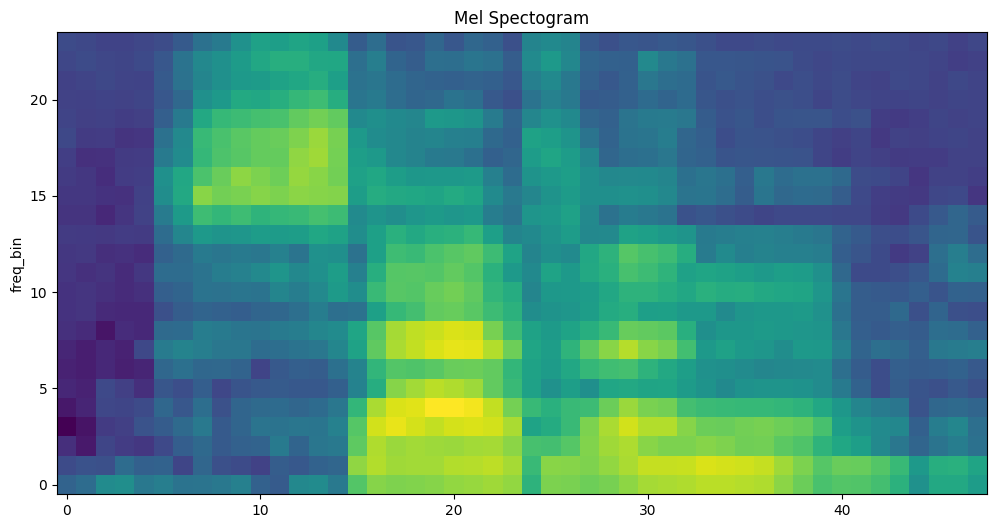

In [45]:
class AudioDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, i):
        path_to_audio, class_label = self.df.iloc[i]
        print(path_to_audio)
        waveform, _ = torchaudio.load(path_to_audio, normalize=True)

        specgram = self.transform(waveform)

        return specgram, class_label

    def __len__(self):
        return self.df.shape[0]


ds = AudioDataset(audio_df, transform)
sample = ds[0]
plot_spectogram(sample[0][0], 'Mel Spectogram')
print(f'sample.shape: {sample[0].shape}, sample.class: {sample[1]}')
plt.savefig('sample.png')

In [40]:
img = cv2.imread('sample.png')

bilateral = cv2.bilateralFilter(img, 45, 75, 75)

cv2.imwrite('sample_bilateral.png', bilateral)

True